### Import necessary modules

In [229]:

from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler


import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from shapely.geometry import Point
import requests, json, random, time, tqdm, warnings
seed=111
path='/Users/Christian/Dropbox/Universitet/TSODAS/TSDS-gruppe-2019/Exam/Scraping/'

### Loading data

In [230]:
r1=pd.read_pickle(path+'prices_0_200.pkl')
r2=pd.read_pickle(path+'prices_200_578.pkl')
r3=pd.read_pickle(path+'prices_577_777.pkl')
r4=pd.read_pickle(path+'prices_777_1000.pkl')
r5=pd.read_pickle(path+'prices_1000_1500.pkl')
r6=pd.read_pickle(path+'prices_1500_2000.pkl')
r7=pd.read_pickle(path+'prices_2000_3000.pkl')
r8=pd.read_pickle(path+'prices_3000_3240.pkl')
r9=pd.read_pickle(path+'prices_3240_4000.pkl')
r10=pd.read_pickle(path+'prices_4000_.pkl')
#print(len(r1), len(r2), len(r3), len(r4), len(r5), len(r6))
r=r1.append(r2, ignore_index=True)
r=r.append(r3, ignore_index=True)
r=r.append(r4, ignore_index=True)
r=r.append(r5, ignore_index=True)
r=r.append(r6, ignore_index=True)
r=r.append(r7, ignore_index=True)
r=r.append(r8, ignore_index=True)
r=r.append(r9, ignore_index=True)
r=r.append(r10, ignore_index=True)


r.to_pickle('scraping_data.pkl')


FileNotFoundError: [Errno 2] No such file or directory: '/Users/Christian/Dropbox/Universitet/TSODAS/TSDS-gruppe-2019/Exam/prices_0_200.pkl'

### Cleaning

In [276]:
r=pd.read_pickle('scraping_data.pkl')
t=pd.read_pickle(path+'/Prediction/missings_190528.pkl')
r=r.append(t, ignore_index=True)
missings2018_1= pd.read_pickle('missings_2018_del1.pkl')
missings2018_2= pd.read_pickle('missings_2018_del2.pkl')
missings2018_3= pd.read_pickle('missings_2018_del3.pkl')
r=r.append(missings2018_1, ignore_index=True)
r=r.append(missings2018_2, ignore_index=True)
r=r.append(missings2018_3, ignore_index=True)

r=r.loc[(r.price !='-') & (r.price != 'Ingen')]
r=r.drop_duplicates(['origin','destination'])
r['price']=r['price'].str[4:].str.replace('.','')
r['price']=pd.to_numeric(r.price, errors='coerce')
r=r.drop_duplicates(['origin','destination'])
pred=pd.read_pickle(path+'FlightsML18.pkl')
print(len(pred))
pred_data=r.merge(pred, how='right', left_on=['origin','destination'], right_on=['Origin', 'Dest'])

pred_data.drop_duplicates(['origin','destination'], inplace=True)
missings = pred_data[pred_data['price'].isna()==True]
missings = missings[missings['count']>52]
missings = missings[missings['day'].isna()==True]
missings = missings[['Origin','Dest']]
missings.to_pickle('missings18.pkl')
pred_data=pred_data[pred_data['count']>=52]
pred_data = pred_data[pred_data['price'].isna()!=True]
print(len(pred_data))
pred_data = pred_data[pred_data['price']<5000]
print(len(pred_data))

pred_data.to_pickle('pred_data_2018.pkl')

6425
5283
5083


,alternative,day,destination,label,origin,price,Origin,Dest,Distance,count,avg_time_mins,companies,Origin_flights,Destination_flights,origin_degree,dest_degree,origin_btwns,dest_btwns,origin_clustcoef,dest_clustcoef
0,,0.0,ONT,1 omstigning,SMF,898.0,SMF,ONT,390.0,2395,71.017647,1,94225,42556,36.0,18.0,0.000748,0.000041,0.717460,0.888889
1,NaN,0.0,PDX,Direkte,SMF,1190.0,SMF,PDX,479.0,1901,84.694737,3,94225,126145,36.0,56.0,0.000748,0.004304,0.717460,0.536364
2,NaN,0.0,PHX,Direkte,SMF,1003.0,SMF,PHX,647.0,3596,106.674223,4,94225,349629,36.0,101.0,0.000748,0.032003,0.717460,0.319208
3,NaN,0.0,SAN,Direkte,SMF,570.0,SMF,SAN,480.0,4886,83.949443,2,94225,182781,36.0,65.0,0.000748,0.007385,0.717460,0.532692
4,NaN,0.0,SEA,Direkte,SMF,905.0,SMF,SEA,605.0,3888,114.971984,3,94225,280007,36.0,82.0,0.000748,0.037868,0.717460,0.400783
5,,0.0,SNA,1 omstigning,SMF,1094.0,SMF,SNA,404.0,2298,79.232416,1,94225,83290,36.0,24.0,0.000748,0.000047,0.717460,0.898551
6,NaN,0.0,LAS,Direkte,SNA,820.0,SNA,LAS,226.0,3561,64.307671,2,83290,324648,24.0,117.0,0.000047,0.043202,0.898551,0.260094
7,Ingen,0.0,MDW,1 omstigning,SNA,2108.0,SNA,MDW,1731.0,96,228.000000,1,83290,174182,24.0,68.0,0.000047,0.002312,0.898551,0.497805
8,NaN,0.0,OAK,Direkte,SNA,1688.0,SNA,OAK,371.0,2595,77.045331,1,83290,105326,24.0,51.0,0.000047,0.003688,0.898551,0.512157
9,NaN,0.0,PHX,Direkte,SNA,1096.0,SNA,PHX,338.0,4117,73.995102,2,83290,349629,24.0,101.0,0.000047,0.032003,0.898551,0.319208


### Creating data sets

In [277]:
pred_data=pd.read_pickle('pred_data_2018.pkl')
X_base=pred_data[['Distance','count', 'avg_time_mins', 'Origin_flights', 'Destination_flights','companies','Origin','Dest', 'label']]
y_base=pred_data['price']

X=pred_data[['Distance','count', 'avg_time_mins', 'Origin_flights', 'Destination_flights','companies', 'origin_degree', 
        'dest_degree', 'origin_btwns', 'dest_btwns','origin_clustcoef', 'dest_clustcoef', 'Origin','Dest', 'label']]
y=pred_data['price']

X_base=pd.get_dummies(data=X_base, columns=['companies','Origin', 'Dest', 'label'])
X=pd.get_dummies(data=X, columns=['companies','Origin', 'Dest', 'label'])
#X.drop(['Origin','Dest'], inplace=True, axis=1)

### Correlation plot

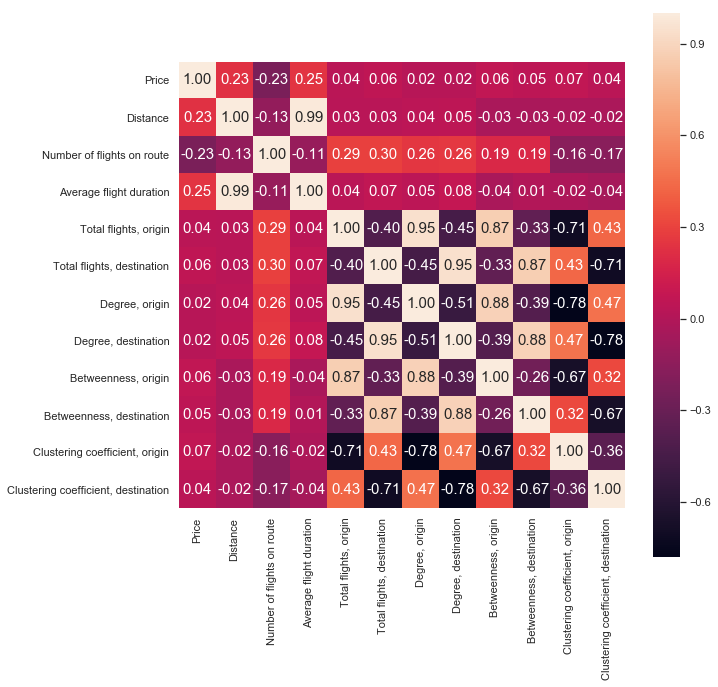

In [278]:
# Look at the Correlation matrix
cols = ['price','Distance','count', 'avg_time_mins', 'Origin_flights', 'Destination_flights', 'origin_degree', 
        'dest_degree', 'origin_btwns', 'dest_btwns', 'origin_clustcoef', 'dest_clustcoef']
names = ['Price', 'Distance', 'Number of flights on route', 'Average flight duration', 'Total flights, origin',
        'Total flights, destination', 'Degree, origin', 'Degree, destination', 'Betweenness, origin',
        'Betweenness, destination', 'Clustering coefficient, origin', 'Clustering coefficient, destination']
fig4, hm = plt.subplots(figsize=(10,10))
cm = np.corrcoef(pred_data[cols].values.T)
sns.set(font_scale=1)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 15}, yticklabels=names, xticklabels=names)
plt.savefig(path+"Figures/corr_plot.pdf", bbox_inches='tight')


### Splitting data

In [279]:
# Splitting the data into test and training
X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=1/4, random_state=1)
X_dev_base, X_test_base, y_dev_base, y_test_base = train_test_split(X_base, y_base, test_size=1/4, random_state=1)



### Estimating network model

In [280]:
# Scaling data
scaler = StandardScaler()
scaler.fit(X_dev)
X_dev=scaler.transform(X_dev)

# Create the hyperparameter grid
l1_space = [0.25,0.5,0.75,1]
alpha = np.linspace(1, 20, 40)
param_grid = {'alpha':alpha, 'l1_ratio': l1_space}

# Instantiate the ElasticNet regressor: elastic_net
elastic_net = ElasticNet(tol=0.0001, max_iter=2000)

# Setup the GridSearchCV object: gm_cv
gm_cv = GridSearchCV(elastic_net, param_grid, cv=5, return_train_score=True)

# Fit it to the training data
gm_cv.fit(X_dev, y_dev)

scaler.fit(X_test)
X_test=scaler.transform(X_test)
# Predict on the test set and compute metrics
y_pred_train = gm_cv.predict(X_dev)
y_pred = gm_cv.predict(X_test)
r2 = gm_cv.score(X_test, y_test)
mse = mean_squared_error(y_test, y_pred)

print("Tuned ElasticNet l1 ratio: {}".format(gm_cv.best_params_))
print("Tuned ElasticNet R squared: {}".format(r2))
print("Tuned ElasticNet MSE: {}".format(mse))


/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.


Tuned ElasticNet l1 ratio: {'alpha': 5.871794871794871, 'l1_ratio': 1}
Tuned ElasticNet R squared: 0.4258964533403014
Tuned ElasticNet MSE: 371119.16821894696


/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.


### Computing training data statistics for network model

In [281]:
k=cross_val_score(ElasticNet(tol=0.001, alpha=5.871794871794871, l1_ratio=1), X=X_dev, y=y_dev, cv=5)
k2=cross_val_predict(ElasticNet(tol=0.0001, alpha=5.871794871794871, l1_ratio=1), X=X_dev, y=y_dev, cv=5)
mse=mean_squared_error(y_dev, k2)
r2=np.mean(k)
r2_std=np.std(k)
print(mse, r2, r2_std)

356003.24920761987 0.43078841962051995 0.028113057072532272


### Validation Curve

In [ ]:

scores=[]
for a in range(1,15,1):
    k=cross_val_score(ElasticNet(tol=0.001, alpha=a, l1_ratio=1), X=X_dev, y=y_dev, cv=5)   
    score=np.mean(k)
    score_std=np.std(k)
    data={'alpha':a, 'score':score, 'std':score_std}
    #df=pd.DataFrame(data)
    scores.append(data)
scores=pd.DataFrame(scores)

scores_l1=[]
for a in range(1,15,1):
    k=cross_val_score(ElasticNet(tol=0.001, alpha=a, l1_ratio=0.75), X=X_dev, y=y_dev, cv=5)   
    score=np.mean(k)
    score_std=np.std(k)
    data={'alpha':a, 'score':score, 'std':score_std}
    #df=pd.DataFrame(data)
    scores_l1.append(data)
scores_l1=pd.DataFrame(scores_l1)

scores_l1_2=[]
for a in range(1,15,1):
    k=cross_val_score(ElasticNet(tol=0.001, alpha=a, l1_ratio=0.5), X=X_dev, y=y_dev, cv=5)   
    score=np.mean(k)
    score_std=np.std(k)
    data={'alpha':a, 'score':score, 'std':score_std}
    #df=pd.DataFrame(data)
    scores_l1_2.append(data)
scores_l1_2=pd.DataFrame(scores_l1_2)

scores_test=[]
for a in range(1,15,1):
    k=ElasticNet(tol=0.001, alpha=a, l1_ratio=1)
    k.fit(X=X_dev, y=y_dev)
    score=k.score(X_test, y_test)
    data={'alpha':a, 'score':score}
    #df=pd.DataFrame(data)
    scores_test.append(data)
scores_test=pd.DataFrame(scores_test)



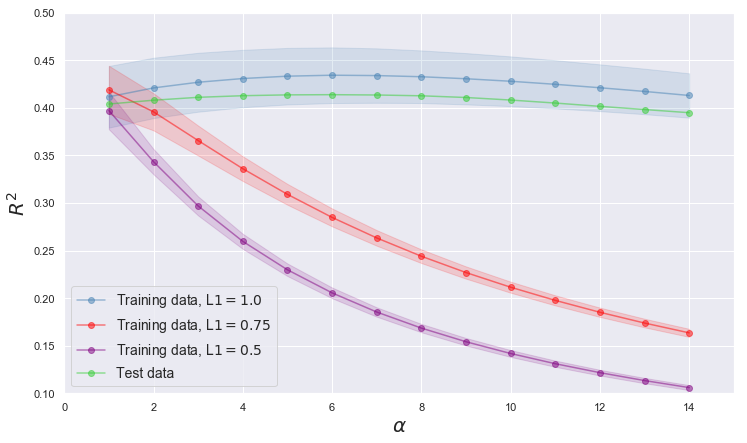

In [203]:
scores['conf1']=scores['score'] + scores['std']
scores['conf2']=scores['score'] - scores['std']
scores_l1['conf1']=scores_l1['score'] + scores_l1['std']
scores_l1['conf2']=scores_l1['score'] - scores_l1['std']
scores_l1_2['conf1']=scores_l1_2['score'] + scores_l1_2['std']
scores_l1_2['conf2']=scores_l1_2['score'] - scores_l1_2['std']
plt.figure(figsize=(12,7))
plt.plot(scores.alpha , scores.score,
    c='steelblue', marker='o',
    label='Training data, L$1=1.0$', alpha=0.5)
plt.plot(scores_l1.alpha , scores_l1.score,
    c='red', marker='o',
    label='Training data, L$1=0.75$', alpha=0.5)
plt.plot(scores_l1_2.alpha , scores_l1_2.score,
    c='purple', marker='o',
    label='Training data, L$1=0.5$', alpha=0.5)
plt.plot(scores_test.alpha , scores_test.score,
    c='limegreen', marker='o',
    label='Test data', alpha=0.5)
plt.fill_between(scores.alpha , scores.conf1,
    scores.conf2, alpha=0.15,
    color='steelblue')
plt.fill_between(scores_l1.alpha , scores_l1.conf1,
    scores_l1.conf2, alpha=0.15,
    color='red')
plt.fill_between(scores_l1_2.alpha , scores_l1_2.conf1,
    scores_l1_2.conf2, alpha=0.15,
    color='purple')
plt.xlabel('$\\alpha$', fontsize=20)
plt.ylabel('$R^2$', fontsize=20)
plt.legend(loc='lower left', fontsize=14)
plt.hlines(y=0, xmin=-10, xmax=50, color='black', lw=2)
plt.xlim([0, 15])
plt.ylim([0.1, 0.5])
plt.savefig(path+"Figures/validation_curve.pdf", bbox_inches='tight')
plt.show()


### Residuals plot

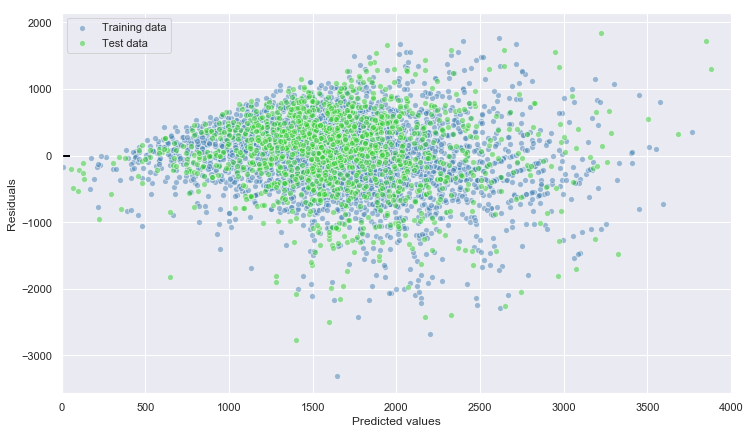

In [274]:
# Residuals plot
plt.figure(figsize=(12,7))
y_pred_train = gm_cv.predict(X_dev)
res_pred_test = y_pred-y_test
res_pred_train = y_pred_train-y_dev
plt.scatter(y_pred_train, res_pred_train ,
    c='steelblue', marker='o', edgecolor='white',
    label='Training data', alpha=0.5)
plt.scatter(y_pred, res_pred_test,
    c='limegreen', marker='o', edgecolor='white',
    label='Test data', alpha=0.5)
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-10, xmax=50, color='black', lw=2)
plt.xlim([0,4000])
plt.show()

### Estimating baseline model

In [282]:
#Without network

# Create the hyperparameter grid

scaler.fit(X_dev_base)
X_dev_base=scaler.transform(X_dev_base)

l1_space = [0.25,0.5,0.75,1]
alpha = np.linspace(1, 20, 40)
param_grid = {'l1_ratio': l1_space, 'alpha':alpha}

# Instantiate the ElasticNet regressor: elastic_net
elastic_net = ElasticNet(tol=0.0001, max_iter=2000)

# Setup the GridSearchCV object: gm_cv
gm_cv_base = GridSearchCV(elastic_net, param_grid, cv=5)

# Fit it to the training data
gm_cv_base.fit(X_dev_base, y_dev_base)

scaler.fit(X_test_base)
X_test_base=scaler.transform(X_test_base)

# Predict on the test set and compute metrics
y_pred_base_train = gm_cv_base.predict(X_dev_base)
y_pred_base = gm_cv_base.predict(X_test_base)
r2 = gm_cv_base.score(X_test_base, y_test_base)
mse = mean_squared_error(y_test_base, y_pred_base)

print("Tuned ElasticNet l1 ratio: {}".format(gm_cv_base.best_params_))
print("Tuned ElasticNet R squared: {}".format(r2))
print("Tuned ElasticNet MSE: {}".format(mse))


/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  


Tuned ElasticNet l1 ratio: {'alpha': 6.358974358974359, 'l1_ratio': 1}
Tuned ElasticNet R squared: 0.4206743676545512
Tuned ElasticNet MSE: 374494.8939174549


/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.


### Computing training data statistics for baseline model

In [283]:
k=cross_val_score(ElasticNet(tol=0.0001, alpha=6.358974358974359, l1_ratio=1), X=X_dev_base, y=y_dev_base, cv=5)
k2=cross_val_predict(ElasticNet(tol=0.0001, alpha=6.358974358974359, l1_ratio=1), X=X_dev_base, y=y_dev_base, cv=5)
mse=mean_squared_error(y_dev_base, k2)
r2=np.mean(k)
r2_std=np.std(k)
print(mse, r2, r2_std)

358446.10051798995 0.42703864871069663 0.02568344820082743


### Comparing coefficients 

In [287]:
coef_model_net=pd.DataFrame(gm_cv.best_estimator_.coef_[0:11])
coef_model_base=pd.DataFrame(gm_cv_base.best_estimator_.coef_[0:5])

var=['Distance','count', 'avg_time_mins', 'Origin_flights', 
    'Destination_flights','origin_degree', 'dest_degree', 'origin_btwns', 
    'dest_btwns','origin_clustcoef', 'dest_clustcoef']
var=pd.DataFrame(var)


coefs=pd.concat([var,coef_model_base,coef_model_net], axis=1)
coefs.columns=['Variable','Baseline model','Network model']
coefs.set_index('Variable', inplace=True)
coefs=coefs.round(2)
with open('coefs.tex', 'w') as tf:
     tf.write(coefs.to_latex(na_rep=""))
print(coefs.to_latex)

<bound method NDFrame.to_latex of                      Baseline model  Network model
Variable                                          
Distance                       0.00           0.00
count                       -160.62        -149.12
avg_time_mins                233.13         244.41
Origin_flights                 0.00           0.00
Destination_flights           16.40          21.87
origin_degree                   NaN           0.00
dest_degree                     NaN           0.00
origin_btwns                    NaN          26.84
dest_btwns                      NaN           0.00
origin_clustcoef                NaN          81.56
dest_clustcoef                  NaN          30.99>


### Without airport fixed effects

In [288]:
pred_data=pd.read_pickle('pred_data_2018.pkl')
X_base=pred_data[['Distance','count', 'avg_time_mins', 'Origin_flights', 'Destination_flights','companies', 'label']]
y_base=pred_data['price']

X=pred_data[['Distance','count', 'avg_time_mins', 'Origin_flights', 'Destination_flights','companies', 'origin_degree', 
        'dest_degree', 'origin_btwns', 'dest_btwns','origin_clustcoef', 'dest_clustcoef', 'label']]
y=pred_data['price']

X_base=pd.get_dummies(data=X_base, columns=['companies', 'label'])
X=pd.get_dummies(data=X, columns=['companies', 'label'])

# Splitting the data into test and training
X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=1/4, random_state=1)
X_dev_base, X_test_base, y_dev_base, y_test_base = train_test_split(X_base, y_base, test_size=1/4, random_state=1)



In [289]:
#Scaling data
scaler = StandardScaler()
scaler.fit(X_dev)
X_dev=scaler.transform(X_dev)

# Create the hyperparameter grid
l1_space = [0.25,0.5,0.75,1]
alpha = np.linspace(1, 20, 40)
param_grid = {'alpha':alpha, 'l1_ratio': l1_space}

# Instantiate the ElasticNet regressor: elastic_net
elastic_net = ElasticNet(tol=0.0001, max_iter=2000)

# Setup the GridSearchCV object: gm_cv
gm_cv = GridSearchCV(elastic_net, param_grid, cv=5, return_train_score=True)

# Fit it to the training data
gm_cv.fit(X_dev, y_dev)

scaler.fit(X_test)
X_test=scaler.transform(X_test)
# Predict on the test set and compute metrics
y_pred_train = gm_cv.predict(X_dev)
y_pred = gm_cv.predict(X_test)
r2 = gm_cv.score(X_test, y_test)
mse = mean_squared_error(y_test, y_pred)

print("Tuned ElasticNet l1 ratio: {}".format(gm_cv.best_params_))
print("Tuned ElasticNet R squared: {}".format(r2))
print("Tuned ElasticNet MSE: {}".format(mse))



/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.


Tuned ElasticNet l1 ratio: {'alpha': 1.0, 'l1_ratio': 1}
Tuned ElasticNet R squared: 0.17906888347251362
Tuned ElasticNet MSE: 530676.5215148933


/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.


In [290]:
#Without network

# Create the hyperparameter grid

scaler.fit(X_dev_base)
X_dev_base=scaler.transform(X_dev_base)

l1_space = [0.25,0.5,0.75,1]
alpha = np.linspace(1, 20, 40)
param_grid = {'l1_ratio': l1_space, 'alpha':alpha}

# Instantiate the ElasticNet regressor: elastic_net
elastic_net = ElasticNet(tol=0.0001, max_iter=2000)

# Setup the GridSearchCV object: gm_cv
gm_cv_base = GridSearchCV(elastic_net, param_grid, cv=5)

# Fit it to the training data
gm_cv_base.fit(X_dev_base, y_dev_base)

scaler.fit(X_test_base)
X_test_base=scaler.transform(X_test_base)

# Predict on the test set and compute metrics
y_pred_base_train = gm_cv_base.predict(X_dev_base)
y_pred_base = gm_cv_base.predict(X_test_base)
r2 = gm_cv_base.score(X_test_base, y_test_base)
mse = mean_squared_error(y_test_base, y_pred_base)

print("Tuned ElasticNet l1 ratio: {}".format(gm_cv_base.best_params_))
print("Tuned ElasticNet R squared: {}".format(r2))
print("Tuned ElasticNet MSE: {}".format(mse))



/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  


Tuned ElasticNet l1 ratio: {'alpha': 1.0, 'l1_ratio': 1}
Tuned ElasticNet R squared: 0.15862247615112257
Tuned ElasticNet MSE: 543893.7429069749


/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.


In [291]:
coef_model_net=pd.DataFrame(gm_cv.best_estimator_.coef_[0:11])
coef_model_base=pd.DataFrame(gm_cv_base.best_estimator_.coef_[0:5])

var=['Distance','count', 'avg_time_mins', 'Origin_flights', 
    'Destination_flights','origin_degree', 'dest_degree', 'origin_btwns', 
    'dest_btwns','origin_clustcoef', 'dest_clustcoef']
var=pd.DataFrame(var)


coefs=pd.concat([var,coef_model_base,coef_model_net], axis=1)
coefs.columns=['Variable','Baseline model','Network model']
coefs.set_index('Variable', inplace=True)
coefs=coefs.round(2)
with open('coefs.tex', 'w') as tf:
     tf.write(coefs.to_latex(na_rep=""))
print(coefs.to_latex)

<bound method NDFrame.to_latex of                      Baseline model  Network model
Variable                                          
Distance                    -206.95        -207.36
count                       -219.34        -197.98
avg_time_mins                344.61         366.21
Origin_flights               202.58         150.56
Destination_flights          209.51         387.79
origin_degree                   NaN           0.00
dest_degree                     NaN        -225.21
origin_btwns                    NaN         107.86
dest_btwns                      NaN          21.12
origin_clustcoef                NaN         144.89
dest_clustcoef                  NaN          58.01>
